<a href="https://colab.research.google.com/github/akchandru28/Taskdatascience/blob/main/consumer_complaint_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [25]:
import pandas as pd

# URL of the zipped CSV file
url = 'https://files.consumerfinance.gov/ccdb/complaints.csv.zip'


target_categories = {
    'Credit reporting, repair, or other': 0,
    'Debt collection': 1,
    'Consumer Loan': 2,
    'Mortgage': 3
}


filtered_data = []
use_cols = ['Product', 'Consumer complaint narrative']
for chunk in pd.read_csv(url, compression='zip', usecols=use_cols, chunksize=10000, low_memory=False):

    chunk.dropna(inplace=True)
    chunk = chunk[chunk['Product'].isin(target_categories.keys())].copy()
    chunk['label'] = chunk['Product'].map(target_categories)
    chunk = chunk.rename(columns={'Consumer complaint narrative': 'text'})
    filtered_data.append(chunk[['text', 'label']])

df = pd.concat(filtered_data, ignore_index=True)


print(df.head())


                                                text  label
0  I purchased a home from Illinois to move to Lo...      3
1  I've complained about procollect and this fals...      1
2  Credit Collections obtained access to my consu...      1
3  First of all, I never received any email or of...      1
4  I was not served to appear in court for either...      1


In [26]:
#1. Explanatory Data Analysis and Feature Engineering

Dataset Shape: (471608, 2)
Class distribution:
label
1    332438
3    129709
2      9461
Name: count, dtype: int64


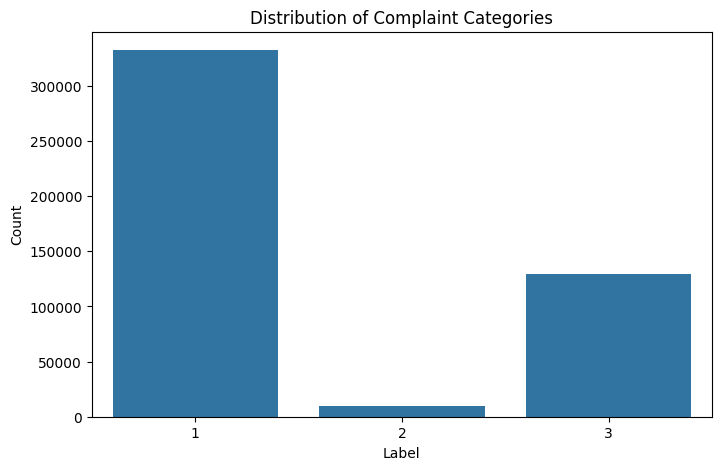

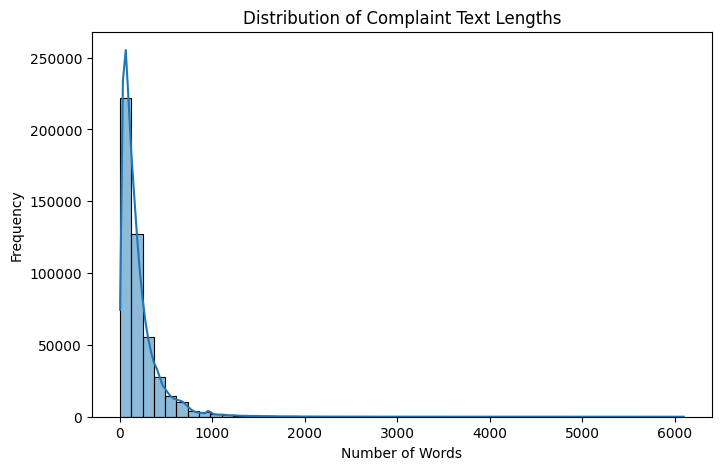

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns


print("Dataset Shape:", df.shape)
print("Class distribution:")
print(df['label'].value_counts())


plt.figure(figsize=(8,5))
sns.countplot(x='label', data=df)
plt.title('Distribution of Complaint Categories')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()


df['text_length'] = df['text'].apply(lambda x: len(x.split()))

plt.figure(figsize=(8,5))
sns.histplot(df['text_length'], bins=50, kde=True)
plt.title("Distribution of Complaint Text Lengths")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.show()


In [28]:
#2. Text Preprocessing

In [29]:
import re
import nltk
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))


def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z]', ' ', text)
    text = ' '.join([word for word in text.split() if word not in stop_words])
    return text


df['clean_text'] = df['text'].apply(clean_text)
vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(df['clean_text'])
y = df['label']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [30]:
# 3. Model Selection – Multiclass Classification

In [31]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC

models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, solver='saga'),
    'Naive Bayes': MultinomialNB(),
    'Linear SVM': LinearSVC()
}


In [32]:
# 4.Compare Model Performance

In [33]:
from sklearn.metrics import accuracy_score, classification_report
import time

for name, model in models.items():
    print(f"\nTraining {name}...")
    start = time.time()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    end = time.time()

    print(f"{name} Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print(f"Training Time: {end - start:.2f} seconds")
    print(f"Classification Report:\n{classification_report(y_test, y_pred)}")



Training Logistic Regression...
Logistic Regression Accuracy: 0.9678
Training Time: 18.33 seconds
Classification Report:
              precision    recall  f1-score   support

           1       0.97      0.98      0.98     66488
           2       0.76      0.48      0.59      1892
           3       0.96      0.96      0.96     25942

    accuracy                           0.97     94322
   macro avg       0.90      0.81      0.84     94322
weighted avg       0.97      0.97      0.97     94322


Training Naive Bayes...
Naive Bayes Accuracy: 0.9513
Training Time: 0.16 seconds
Classification Report:
              precision    recall  f1-score   support

           1       0.97      0.97      0.97     66488
           2       0.69      0.29      0.41      1892
           3       0.91      0.96      0.93     25942

    accuracy                           0.95     94322
   macro avg       0.86      0.74      0.77     94322
weighted avg       0.95      0.95      0.95     94322


Training L

In [34]:
# 5.Model Evaluation


Confusion Matrix for Logistic Regression


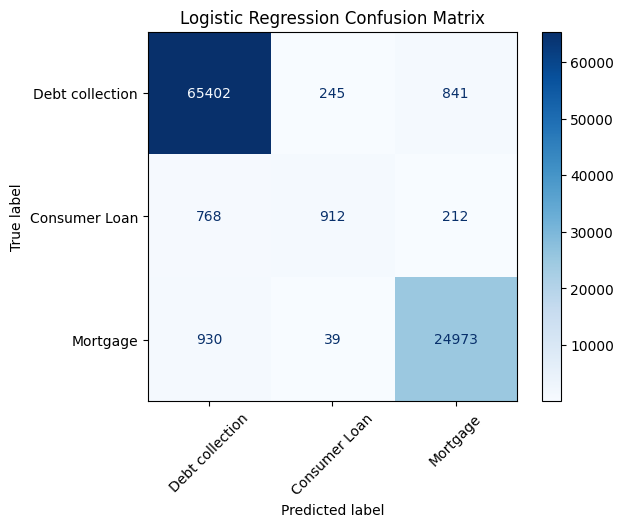


Confusion Matrix for Naive Bayes


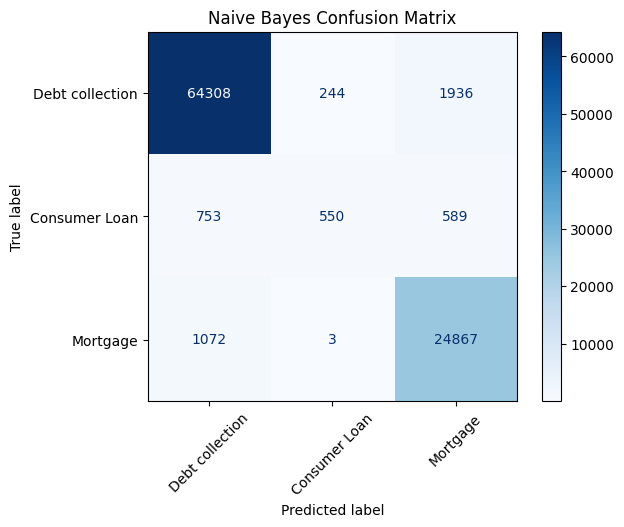


Confusion Matrix for Linear SVM


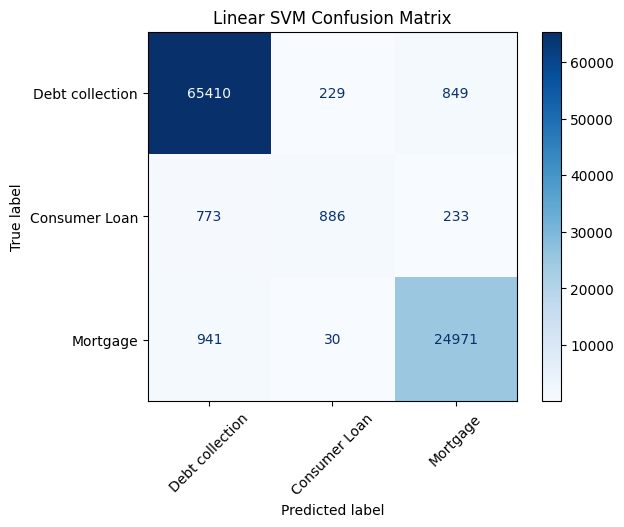

In [35]:
import numpy as np

for name, model in models.items():
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)


    labels_used = np.unique(np.concatenate((y_test, y_pred)))
    label_names = [list(target_categories.keys())[list(target_categories.values()).index(i)] for i in labels_used]

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)
    print(f"\nConfusion Matrix for {name}")
    disp.plot(cmap='Blues', xticks_rotation=45)
    plt.title(f"{name} Confusion Matrix")
    plt.show()


In [36]:
# 6.Prediction Function

In [37]:
# I am using Logistic Regression.
best_model = models['Logistic Regression']
def predict_category(text):
    cleaned = clean_text(text)
    vectorized = vectorizer.transform([cleaned])
    label = best_model.predict(vectorized)[0]
    return list(target_categories.keys())[list(target_categories.values()).index(label)]

sample_input = "I got an incorrect credit report that I can't fix."
print("Predicted Category:", predict_category(sample_input))


Predicted Category: Debt collection
